# Predictive Modeling of Flight Delays for Commercial Flights

In [197]:
#Importing required packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from dmba.metric import AIC_score

In [4]:
#Reading the dataset
df = pd.read_csv("FlightDelays.csv")

#Checking and first look
df.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,37987,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,2004-01-01,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,2004-01-01,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,2004-01-01,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,2004-01-01,7792,IAD,0,4,1,N698BR,ontime


# Data Cleaning

In [6]:
# Dataset summary for data types and null values

# show the number of rows and columns for  dataset
print('Dataframe dimensions:', df.shape)

# gives some infomations on columns types and number of null values
df_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
df_info=df_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values:'}))
df_info=df_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
df_info

Dataframe dimensions: (2201, 13)


C:\Users\kkere\AppData\Local\Temp\ipykernel_16532\857009775.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_info=df_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values:'}))
C:\Users\kkere\AppData\Local\Temp\ipykernel_16532\857009775.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_info=df_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))


,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
column type,int64,object,int64,object,int64,object,int64,object,int64,int64,int64,object,object
null values:,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
#Replacing 37987 with 2004-01-01 for FL_DATE
df['FL_DATE'].replace({'37987':'2004-01-01'}, inplace=True)

#Reformatting date column
df["FL_DATE"] = pd.to_datetime(df["FL_DATE"])
df.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,2004-01-01,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,2004-01-01,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,2004-01-01,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,2004-01-01,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,2004-01-01,7792,IAD,0,4,1,N698BR,ontime


# A. Data Preprocessing

## 1. Data Reduction

In [12]:
#FL_DATE is redundant because week and month is stored in another columns
#FL_NUM and TAIL_NUM will not contribute to delays

#Dropping FL_DATE, FL_NUM, TAIL_NUM
df.drop('FL_DATE', axis=1, inplace=True)
df.drop('FL_NUM', axis=1, inplace=True)
df.drop('TAIL_NUM', axis=1, inplace=True)
df.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,Flight Status
0,1455,OH,1455,JFK,184,BWI,0,4,1,ontime
1,1640,DH,1640,JFK,213,DCA,0,4,1,ontime
2,1245,DH,1245,LGA,229,IAD,0,4,1,ontime
3,1715,DH,1709,LGA,229,IAD,0,4,1,ontime
4,1039,DH,1035,LGA,229,IAD,0,4,1,ontime


In [14]:
#Creating dummy variable for 'Flight Status' to use correlation matrix
df['delayed'] = np.where((df['Flight Status'] == 'ontime'),0,1)

In [16]:
#Correlation matrix
corr_matrix = df.corr()
print(corr_matrix)
#CRS_DEP_TIME and DEP_TIME are highly correlated

              CRS_DEP_TIME  DEP_TIME  DISTANCE   Weather  DAY_WEEK  \
CRS_DEP_TIME      1.000000  0.983523  0.062368 -0.008266  0.051766   
DEP_TIME          0.983523  1.000000  0.057680  0.019001  0.051868   
DISTANCE          0.062368  0.057680  1.000000  0.033104 -0.020926   
Weather          -0.008266  0.019001  0.033104  1.000000 -0.123636   
DAY_WEEK          0.051766  0.051868 -0.020926 -0.123636  1.000000   
DAY_OF_MONTH      0.002324  0.000132  0.010121  0.144034  0.015914   
delayed           0.112474  0.170116 -0.018794  0.247217 -0.040756   

              DAY_OF_MONTH   delayed  
CRS_DEP_TIME      0.002324  0.112474  
DEP_TIME          0.000132  0.170116  
DISTANCE          0.010121 -0.018794  
Weather           0.144034  0.247217  
DAY_WEEK          0.015914 -0.040756  
DAY_OF_MONTH      1.000000  0.066598  
delayed           0.066598  1.000000  


In [20]:
#Creating a new variable for departure delay where departure time is later than scheduled departure time
df['DEP_DELAY'] = np.where((df['DEP_TIME']-df['CRS_DEP_TIME'] > 0),(df['DEP_TIME']-df['CRS_DEP_TIME']),0)
df.head(15)

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,Flight Status,delayed,DEP_DELAY
0,1455,OH,1455,JFK,184,BWI,0,4,1,ontime,0,0
1,1640,DH,1640,JFK,213,DCA,0,4,1,ontime,0,0
2,1245,DH,1245,LGA,229,IAD,0,4,1,ontime,0,0
3,1715,DH,1709,LGA,229,IAD,0,4,1,ontime,0,0
4,1039,DH,1035,LGA,229,IAD,0,4,1,ontime,0,0
5,840,DH,839,JFK,228,IAD,0,4,1,ontime,0,0
6,1240,DH,1243,JFK,228,IAD,0,4,1,ontime,0,3
7,1645,DH,1644,JFK,228,IAD,0,4,1,ontime,0,0
8,1715,DH,1710,JFK,228,IAD,0,4,1,ontime,0,0
9,2120,DH,2129,JFK,228,IAD,0,4,1,ontime,0,9


In [21]:
#Dropping 'CRS_DEP_TIME', 'DEP_TIME' and dummy variable 'delayed'
df.drop('CRS_DEP_TIME', axis=1, inplace=True)
df.drop('DEP_TIME', axis=1, inplace=True)
df.drop('delayed', axis=1, inplace=True)
df.head()

,CARRIER,DEST,DISTANCE,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,Flight Status,DEP_DELAY
0,OH,JFK,184,BWI,0,4,1,ontime,0
1,DH,JFK,213,DCA,0,4,1,ontime,0
2,DH,LGA,229,IAD,0,4,1,ontime,0
3,DH,LGA,229,IAD,0,4,1,ontime,0
4,DH,LGA,229,IAD,0,4,1,ontime,0


In [22]:
#Exporting to csv
df.to_csv(r'C:\Users\kkere\Desktop\BIA 5302 - Machine Learning 1\Project2\FlightDelaysTrainingData.csv', index=False, header=True)

## 2. Data Conversion

In [ ]:
#Naive Bayes requires CATEGORICAL inputs.
#Classification and Regression tree will be used with NUMERICAL inputs.
#Logistic Regression requires NUMERICAL inputs.

### Numerical input dataframe (For CART and Logistic Regression)

In [134]:
#Creating a copy of df for numerical inputs
df_num = df.copy()
df_num.head()

,CARRIER,DEST,DISTANCE,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,Flight Status,DEP_DELAY
0,OH,JFK,184,BWI,0,4,1,ontime,0
1,DH,JFK,213,DCA,0,4,1,ontime,0
2,DH,LGA,229,IAD,0,4,1,ontime,0
3,DH,LGA,229,IAD,0,4,1,ontime,0
4,DH,LGA,229,IAD,0,4,1,ontime,0


In [135]:
#Creating dummy variables for categorical variables 
df_num = pd.get_dummies(df_num, columns = ['CARRIER', 'DEST', 'ORIGIN', 'Weather', 'DAY_WEEK', 'DAY_OF_MONTH'], drop_first=True)
df_num.columns

Index(['DISTANCE', 'Flight Status', 'DEP_DELAY', 'CARRIER_DH', 'CARRIER_DL',
       'CARRIER_MQ', 'CARRIER_OH', 'CARRIER_RU', 'CARRIER_UA', 'CARRIER_US',
       'DEST_JFK', 'DEST_LGA', 'ORIGIN_DCA', 'ORIGIN_IAD', 'Weather_1',
       'DAY_WEEK_2', 'DAY_WEEK_3', 'DAY_WEEK_4', 'DAY_WEEK_5', 'DAY_WEEK_6',
       'DAY_WEEK_7', 'DAY_OF_MONTH_2', 'DAY_OF_MONTH_3', 'DAY_OF_MONTH_4',
       'DAY_OF_MONTH_5', 'DAY_OF_MONTH_6', 'DAY_OF_MONTH_7', 'DAY_OF_MONTH_8',
       'DAY_OF_MONTH_9', 'DAY_OF_MONTH_10', 'DAY_OF_MONTH_11',
       'DAY_OF_MONTH_12', 'DAY_OF_MONTH_13', 'DAY_OF_MONTH_14',
       'DAY_OF_MONTH_15', 'DAY_OF_MONTH_16', 'DAY_OF_MONTH_17',
       'DAY_OF_MONTH_18', 'DAY_OF_MONTH_19', 'DAY_OF_MONTH_20',
       'DAY_OF_MONTH_21', 'DAY_OF_MONTH_22', 'DAY_OF_MONTH_23',
       'DAY_OF_MONTH_24', 'DAY_OF_MONTH_25', 'DAY_OF_MONTH_26',
       'DAY_OF_MONTH_27', 'DAY_OF_MONTH_28', 'DAY_OF_MONTH_29',
       'DAY_OF_MONTH_30', 'DAY_OF_MONTH_31'],
      dtype='object')

In [139]:
# Converting Ordinal Variable Flight Status to numeric
df_num['Flight Status'].replace({'ontime':0, 'delayed':1}, inplace=True)

In [140]:
#Creating the test data for numerical dataframe. Selecting 5 rows.
df_num_test = df_num.iloc[[27, 53, 89, 110, 193],:] 
df_num_test

,DISTANCE,Flight Status,DEP_DELAY,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,CARRIER_RU,CARRIER_UA,CARRIER_US,...,DAY_OF_MONTH_22,DAY_OF_MONTH_23,DAY_OF_MONTH_24,DAY_OF_MONTH_25,DAY_OF_MONTH_26,DAY_OF_MONTH_27,DAY_OF_MONTH_28,DAY_OF_MONTH_29,DAY_OF_MONTH_30,DAY_OF_MONTH_31
27,214,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
53,229,1,76,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89,169,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
110,213,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
193,214,1,36,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [141]:
#Exporting numerical test data to csv
df_num_test.to_csv(r'C:\Users\kkere\Desktop\BIA 5302 - Machine Learning 1\Project2\FlightDelaysTestingData_Num.csv', index=False, header=True)

### Categorical input dataframe (For Naive Bayes)

In [98]:
#Creating a copy of df for categorical inputs
df_cat = df.copy()
df_cat.head()

,CARRIER,DEST,DISTANCE,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,Flight Status,DEP_DELAY
0,OH,JFK,184,BWI,0,4,1,ontime,0
1,DH,JFK,213,DCA,0,4,1,ontime,0
2,DH,LGA,229,IAD,0,4,1,ontime,0
3,DH,LGA,229,IAD,0,4,1,ontime,0
4,DH,LGA,229,IAD,0,4,1,ontime,0


In [99]:
#Converting 'Weather', DAY_WEEK', 'DAY_OF_MONTH' from numerical data into categorical data.
df_cat.Weather =df_cat.Weather.astype('category')
df_cat.DAY_WEEK =df_cat.DAY_WEEK.astype('category')
df_cat.DAY_OF_MONTH =df_cat.DAY_OF_MONTH.astype('category')

In [100]:
#Checking stats of 'DISTANCE'
df_cat['DISTANCE'].describe()

count    2201.000000
mean      211.871422
std        13.316815
min       169.000000
25%       213.000000
50%       214.000000
75%       214.000000
max       229.000000
Name: DISTANCE, dtype: float64

In [101]:
#Binning 'DISTANCE' into categorical (0-190: Low, 191-210: Medium, >210: High)
df_cat['Dist']=pd.cut(df_cat['DISTANCE'], 
                               bins=[0, 190, 210, 999], 
                               labels=['Low', 'Medium', 'High'])

In [102]:
#Dropping 'DISTANCE'
df_cat.drop('DISTANCE', axis=1, inplace=True)
df_cat.head()

,CARRIER,DEST,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,Flight Status,DEP_DELAY,Dist
0,OH,JFK,BWI,0,4,1,ontime,0,Low
1,DH,JFK,DCA,0,4,1,ontime,0,High
2,DH,LGA,IAD,0,4,1,ontime,0,High
3,DH,LGA,IAD,0,4,1,ontime,0,High
4,DH,LGA,IAD,0,4,1,ontime,0,High


In [103]:
#Checking stats of 'DEP_DELAY'
df_cat['DEP_DELAY'].describe()

count    2201.000000
mean       14.370286
std        41.430002
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max       425.000000
Name: DEP_DELAY, dtype: float64

In [104]:
#Binning 'DEP_DELAY' into categorical (If DEP_DELAY > 15: Yes, DEP_DELAY <=15)
df_cat['Delay_Departure']=pd.cut(df_cat['DEP_DELAY'], 
                               bins=[-1, 15, 999], 
                               labels=['No', 'Yes'])

In [105]:
#Dropping 'DEP_DELAY'
df_cat.drop('DEP_DELAY', axis=1, inplace=True)
df_cat.head()

,CARRIER,DEST,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,Flight Status,Dist,Delay_Departure
0,OH,JFK,BWI,0,4,1,ontime,Low,No
1,DH,JFK,DCA,0,4,1,ontime,High,No
2,DH,LGA,IAD,0,4,1,ontime,High,No
3,DH,LGA,IAD,0,4,1,ontime,High,No
4,DH,LGA,IAD,0,4,1,ontime,High,No


In [69]:
#Creating the test data for categorical dataframe. Selecting 5 rows.
df_cat_test = df_cat.iloc[[27, 53, 89, 110, 193],:] 
df_cat_test

,CARRIER,DEST,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,Flight Status,Dist,Delay_Departure
27,US,LGA,DCA,0,4,1,ontime,High,No
53,DH,LGA,IAD,0,5,2,delayed,High,Yes
89,RU,EWR,BWI,0,5,2,ontime,Low,No
110,RU,EWR,IAD,0,5,2,delayed,High,No
193,MQ,LGA,DCA,0,7,4,delayed,High,Yes


In [72]:
#Exporting numerical test data to csv
df_cat_test.to_csv(r'C:\Users\kkere\Desktop\BIA 5302 - Machine Learning 1\Project2\FlightDelaysTestingData_Cat.csv', index=False, header=True)

# B. Model Building

## 1. Naive Bayes

In [202]:
#Split the data into training (60%) and testing (40%)
predictors = ['CARRIER', 'DEST', 'ORIGIN', 'Weather', 'DAY_WEEK', 'DAY_OF_MONTH', 'Dist', 'Delay_Departure']
outcome = 'Flight Status'
X = pd.get_dummies(df_cat[predictors])
y = df_cat['Flight Status']
classes = ['ontime', 'delayed']


In [203]:
#Getting test data
X_test = X.iloc[[27, 53, 89, 110, 193],:] 
y_test = df_cat.iloc[[27, 53, 89, 110, 193], df_cat.columns.get_loc("Flight Status")]
X_test.head()

,CARRIER_CO,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,CARRIER_RU,CARRIER_UA,CARRIER_US,DEST_EWR,DEST_JFK,...,DAY_OF_MONTH_27,DAY_OF_MONTH_28,DAY_OF_MONTH_29,DAY_OF_MONTH_30,DAY_OF_MONTH_31,Dist_Low,Dist_Medium,Dist_High,Delay_Departure_No,Delay_Departure_Yes
27,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
53,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
89,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
110,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
193,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [204]:
#Dropping test rows from the actual data
pos = [27,53,89,110,193]
X.drop(X.index[pos], inplace=True)
y.drop(y.index[pos], inplace=True)

In [205]:
# split into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.40, random_state=1)

In [212]:
# Running the model and printing confusion matrix
nb_classifier = MultinomialNB()

nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

In [213]:
#Confusion Matrix
classificationSummary(y_pred, y_test)

Confusion Matrix (Accuracy 0.8000)

       Prediction
Actual 0 1
     0 2 0
     1 1 2


## 2. Classification and Regression Tree

In [214]:
#Creating X and y data matrices 
x=df_num.drop(labels=['Flight Status'], axis=1)
y=df_num['Flight Status']

In [215]:
#Getting test data
x_test = x.iloc[[27, 53, 89, 110, 193],:] 
y_test = df_num.iloc[[27, 53, 89, 110, 193], df_num.columns.get_loc("Flight Status")]
x_test.head()

,DISTANCE,DEP_DELAY,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,CARRIER_RU,CARRIER_UA,CARRIER_US,DEST_JFK,...,DAY_OF_MONTH_22,DAY_OF_MONTH_23,DAY_OF_MONTH_24,DAY_OF_MONTH_25,DAY_OF_MONTH_26,DAY_OF_MONTH_27,DAY_OF_MONTH_28,DAY_OF_MONTH_29,DAY_OF_MONTH_30,DAY_OF_MONTH_31
27,214,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
53,229,76,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89,169,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110,213,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
193,214,36,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [216]:
#Dropping test rows from the actual data
pos = [27,53,89,110,193]
x.drop(x.index[pos], inplace=True)
y.drop(y.index[pos], inplace=True)

In [217]:
# split into training and validation
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.4, random_state=1)

In [218]:
#Building decision tree model
classTree = DecisionTreeClassifier(criterion='gini')
print('Model prepared')
classTree.fit(train_x, train_y)
print('Training data has been fitted')
print(classTree)

Model prepared
Training data has been fitted
DecisionTreeClassifier()



(process:12892): GLib-GIO-WARNING **: 13:23:36.795: Unexpectedly, UWP app `6760NGPDFLab.PDFX_1.3.47.0_x64__sbe4t8mqwq93a' (AUMId `6760NGPDFLab.PDFX_sbe4t8mqwq93a!App') supports 32 extensions but has no verbs



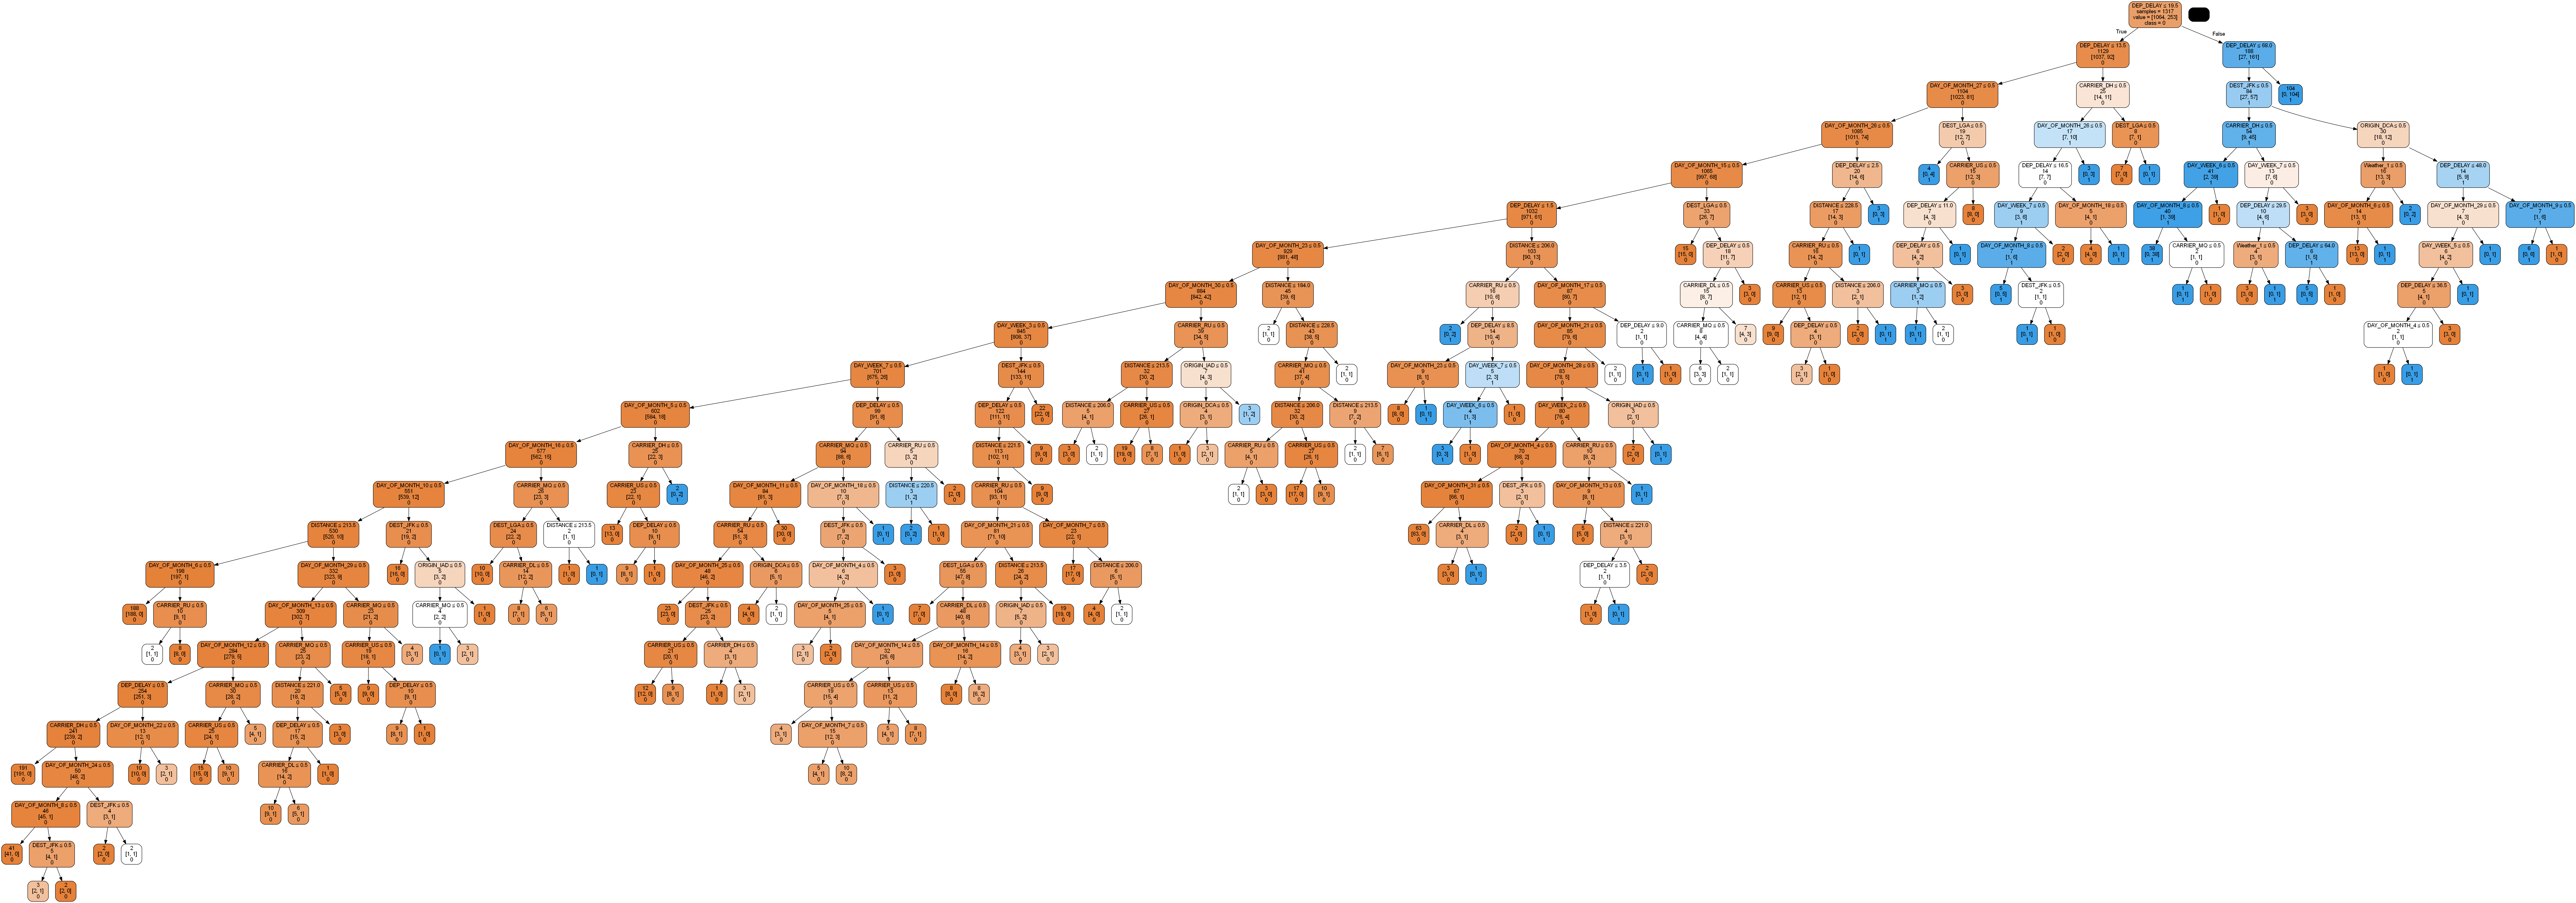

In [219]:
#Plotting the decision tree
plotDecisionTree(classTree, feature_names=x.columns[:], class_names=classTree.classes_)

In [220]:
#Prediction of the test data9[0 1 0 1 1]
prediction = classTree.predict(x_test)
print(prediction)

#0.8 accuracy

[0 1 0 0 1]


In [221]:
#Confusion Matrix
classificationSummary(y_test, prediction)

Confusion Matrix (Accuracy 0.8000)

       Prediction
Actual 0 1
     0 2 0
     1 1 2


## 3. Logistic Regression

In [222]:
#Using same x and y for training and validation, no need to define them again.

# split into training and validation
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.4, random_state=1)

In [226]:
# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg= LogisticRegression(penalty= "l2", C=1e42, solver= 'liblinear')
logit_reg.fit(train_x, train_y)

LogisticRegression(C=1e+42, solver='liblinear')

In [229]:
#Confusion Matrix
classificationSummary(y_test, logit_reg.predict(x_test))

Confusion Matrix (Accuracy 0.6000)

       Prediction
Actual 0 1
     0 2 0
     1 2 1
